In [80]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
import matplotlib.patches as mpatches

import colorsys

import os
import json
import scipy.stats as stats
from scipy.stats import pearsonr
from collections import defaultdict
import tqdm

import sklearn.preprocessing
import sklearn.model_selection
import sklearn.pipeline 
import sklearn.linear_model
import sklearn.ensemble
import sklearn.tree
import sklearn.neighbors

from sklearn.feature_selection import f_regression, SelectKBest, r_regression

import warnings
warnings.filterwarnings(action='ignore',category=sklearn.exceptions.ConvergenceWarning)

In [81]:
metadata = pd.read_csv('./dataset_fingernails/metadata.csv')
target = metadata['HB_LEVEL_GperL']
metadata['NAIL_BOUNDING_BOXES'] = metadata['NAIL_BOUNDING_BOXES'].apply(json.loads)
metadata['SKIN_BOUNDING_BOXES'] = metadata['SKIN_BOUNDING_BOXES'].apply(json.loads)
metadata.shape
metadata.head()

,PATIENT_ID,MEASUREMENT_DATE,HB_LEVEL_GperL,NAIL_BOUNDING_BOXES,SKIN_BOUNDING_BOXES
0,1,14b0293a34344cc4fba0fa39d5370c52,134.0,"[[251, 447, 302, 505], [123, 429, 183, 483], [...","[[267, 586, 324, 627], [148, 556, 200, 614], [..."
1,2,14b0293a34344cc4fba0fa39d5370c52,108.0,"[[236, 503, 281, 556], [148, 457, 195, 514], [...","[[252, 612, 294, 647], [162, 585, 212, 632], [..."
2,5,14b0293a34344cc4fba0fa39d5370c52,84.0,"[[244, 508, 277, 562], [183, 448, 220, 505], [...","[[264, 629, 303, 662], [193, 584, 232, 619], [..."
3,6,14b0293a34344cc4fba0fa39d5370c52,138.0,"[[311, 456, 363, 521], [182, 408, 237, 471], [...","[[318, 609, 380, 650], [189, 562, 245, 616], [..."
4,7,14b0293a34344cc4fba0fa39d5370c52,119.0,"[[29, 513, 78, 556], [119, 435, 165, 479], [18...","[[29, 635, 79, 678], [117, 564, 175, 615], [20..."


In [82]:
image_folder = './dataset_fingernails/photo/'

images = defaultdict(list)

for j,(_, row) in tqdm.tqdm(enumerate(metadata.iterrows())):
    
    img_path = os.path.join(image_folder,f'{row.PATIENT_ID}.jpg')

    img = skio.imread(img_path)
    
    nails_bboxes = row.NAIL_BOUNDING_BOXES
    skin_bboxes  = row.SKIN_BOUNDING_BOXES
    
    for _tissue_site,_bboxes in zip(['NAIL','SKIN'],[nails_bboxes,skin_bboxes]):
        for finger_num,(top,left,bot,right) in enumerate(_bboxes,start=1):
            
            key = f'{_tissue_site}_{finger_num}'
            images[key].append(img[top:bot,left:right])
            
    images['WHITE_REF'].append(img[350:400,300:350])

250it [00:02, 118.05it/s]


In [83]:
percentiles = range(5, 95, 5)

def cut_image(img,low=0.2,high=0.8):
    h,w = img.shape[:2]
    return img[int(low*h):int(high*h),int(low*w):int(high*w),:]

def calculate_hls(img):
    hls = [colorsys.rgb_to_hls(*pixel) for pixel in zip(img[:,:,0].ravel()/255, img[:,:,1].ravel()/255, img[:,:,2].ravel()/255)]
    return hls

def calculate_yiq(img):
    yiq = [colorsys.rgb_to_yiq(*pixel) for pixel in zip(img[:,:,0].ravel()/255, img[:,:,1].ravel()/255, img[:,:,2].ravel()/255)]
    return yiq

def calculate_hsv(img):
    hsv = [colorsys.rgb_to_hsv(*pixel) for pixel in zip(img[:,:,0].ravel()/255, img[:,:,1].ravel()/255, img[:,:,2].ravel()/255)]
    return hsv

def featurize_hls(cutted_images, ref_img, percentiles):
    hls_list = [list(zip(*calculate_hls(img))) for img in cutted_images]
    white_ref_h, white_ref_l, white_ref_s = zip(*calculate_hls(ref_img))
    
    h = np.concatenate([imglist[0] for imglist in hls_list])
    l = np.concatenate([imglist[1] for imglist in hls_list])    
    s = np.concatenate([imglist[2] for imglist in hls_list])

    hls_features = {}

    hls_features['H_MEDIAN'] = np.median(h) / np.median(white_ref_h)
    hls_features['L_MEDIAN'] = np.median(l) / np.median(white_ref_l)
    hls_features['S_MEDIAN'] = np.median(s) / np.median(white_ref_s)

    for color_name, color, ref_color in zip('HLS', [h,l,s], [white_ref_h, white_ref_l, white_ref_s]):
        for percentile_level in percentiles:
            feature_value = np.percentile(color,percentile_level) / np.median(ref_color)
            feature_name = f'{color_name}_p={percentile_level}'
            hls_features[feature_name] = feature_value
    
    return hls_features

def featurize_yiq(cutted_images, ref_img, percentiles):
    yiq_list = [list(zip(*calculate_yiq(img))) for img in cutted_images]
    white_ref_y, white_ref_i, white_ref_q = zip(*calculate_hls(ref_img))

    y = np.concatenate([imglist[0] for imglist in yiq_list])
    i = np.concatenate([imglist[1] for imglist in yiq_list])    
    q = np.concatenate([imglist[2] for imglist in yiq_list])

    yiq_features = {}

    yiq_features['Y_MEDIAN'] = np.median(y) / np.median(white_ref_y)
    yiq_features['I_MEDIAN'] = np.median(i) / np.median(white_ref_i)
    yiq_features['Q_MEDIAN'] = np.median(q) / np.median(white_ref_q)

    for color_name, color, ref_color in zip('YIQ', [y,i,q], [white_ref_y, white_ref_i, white_ref_q]):
        for percentile_level in percentiles:
            feature_value = np.percentile(color,percentile_level) / np.median(ref_color)
            feature_name = f'{color_name}_p={percentile_level}'
            yiq_features[feature_name] = feature_value

    return yiq_features

def featurize_hsv(cutted_images, ref_img, percentiles):
    hsv_list = [list(zip(*calculate_hsv(img))) for img in cutted_images]
    white_ref_h, white_ref_s, white_ref_v = zip(*calculate_hls(ref_img))

    h = np.concatenate([imglist[0] for imglist in hsv_list])
    s = np.concatenate([imglist[1] for imglist in hsv_list])    
    v = np.concatenate([imglist[2] for imglist in hsv_list])

    hsv_features = {}

    hsv_features['H_MEDIAN'] = np.median(h) / np.median(white_ref_h)
    hsv_features['S_MEDIAN'] = np.median(s) / np.median(white_ref_s)
    hsv_features['V_MEDIAN'] = np.median(v) / np.median(white_ref_v)
    
    for color_name, color, ref_color in zip('HSV', [h,s,v], [white_ref_h, white_ref_s, white_ref_v]):
        for percentile_level in percentiles:
            feature_value = np.percentile(color,percentile_level) / np.median(ref_color)
            feature_name = f'{color_name}_p={percentile_level}'
            hsv_features[feature_name] = feature_value

    return hsv_features

def featurize_gsc(cutted_images, ref_img, percentiles):
    # greyscale percentile calculation
    greyscale_imgs = [np.dot(img[...,:3], [1/3, 1/3, 1/3]) for img in cutted_images]
    median_percentile_greyscale_white_ref = np.median(np.dot(ref_img[...,:3], [1/3, 1/3, 1/3]).ravel())
    unraveled_greyscale_imgs = np.concatenate([cutted_image.ravel() for cutted_image in greyscale_imgs])

    greyscale_features = {}

    for percentile_level in percentiles:
        feature_value = np.percentile(unraveled_greyscale_imgs,percentile_level) / median_percentile_greyscale_white_ref
        feature_name = f'gsc_p={percentile_level}'
        greyscale_features[feature_name] = feature_value

    return greyscale_features

def calculate_features(imgs, ref_img, percentile_levels=percentiles, low=0.2,high=0.8):
    features_dict = {}
    cutted_images = [cut_image(img,low=low,high=high) for img in imgs]

    # percentiles calculation for RGB
    for color_chan_id,color in enumerate('RGB'):
        unraveled_images = np.concatenate([cutted_image[:,:,color_chan_id].ravel() for cutted_image in cutted_images])
        median_percentile_white_ref = np.median(ref_img[:,:,color_chan_id].ravel())
        mean_white_ref = np.mean(ref_img[:,:,color_chan_id].ravel())
        std_white_ref = np.std(ref_img[:,:,color_chan_id].ravel())

        feature_mean = np.mean(unraveled_images) / mean_white_ref
        feature_std = np.std(unraveled_images) / std_white_ref

        features_dict[f'{color}_MEAN'] = feature_mean
        features_dict[f'{color}_STD'] = feature_std
    
        for percentile_level in percentile_levels:
            feature_value = np.percentile(unraveled_images,percentile_level) / median_percentile_white_ref
            feature_name = f'{color}_p={percentile_level}'
            features_dict[feature_name] = feature_value

    features_dict[f'R-G_MEAN'] = features_dict['R_MEAN'] - features_dict['G_MEAN']
    features_dict[f'R-B_MEAN'] = features_dict['R_MEAN'] - features_dict['B_MEAN']
    features_dict[f'G-B_MEAN'] = features_dict['G_MEAN'] - features_dict['B_MEAN']
    features_dict[f'R+B_MEAN'] = features_dict['R_MEAN'] + features_dict['B_MEAN']
    
    for percentile_level in percentile_levels:
            feature_name = f'R+B_p={percentile_level}'
            features_dict[feature_name] = features_dict[f'R_p={percentile_level}'] + features_dict[f'B_p={percentile_level}']

    features_dict.update(featurize_hls(imgs, ref_img, percentiles))
    features_dict.update(featurize_hsv(imgs, ref_img, percentiles))
    features_dict.update(featurize_yiq(imgs, ref_img, percentiles))
    features_dict.update(featurize_gsc(imgs, ref_img, percentiles))

    return features_dict

In [84]:
features = pd.DataFrame()

nail_features = pd.DataFrame([calculate_features(imgs, ref_img) for imgs, ref_img in zip(zip(*[images[f'NAIL_{finger_num}'] for finger_num in [1,2,3]]), images['WHITE_REF'])]).rename(columns=lambda x: f'NAIL_{x}')
skin_features = pd.DataFrame([calculate_features(imgs, ref_img) for imgs, ref_img in zip(zip(*[images[f'SKIN_{finger_num}'] for finger_num in [1,2,3]]), images['WHITE_REF'])]).rename(columns=lambda x: f'SKIN_{x}')

# norm_features = pd.DataFrame(nail_features.to_numpy() / skin_features.to_numpy())
# norm_features.columns  = [name.replace('NAIL', 'NORM') for name in nail_features.columns]

features = pd.concat([features, nail_features, skin_features],axis=1)    

features_all = features # to restore the features to its original size when trimmed 

display(features)

,NAIL_R_MEAN,NAIL_R_STD,NAIL_R_p=5,NAIL_R_p=10,NAIL_R_p=15,NAIL_R_p=20,NAIL_R_p=25,NAIL_R_p=30,NAIL_R_p=35,NAIL_R_p=40,...,SKIN_gsc_p=45,SKIN_gsc_p=50,SKIN_gsc_p=55,SKIN_gsc_p=60,SKIN_gsc_p=65,SKIN_gsc_p=70,SKIN_gsc_p=75,SKIN_gsc_p=80,SKIN_gsc_p=85,SKIN_gsc_p=90
0,0.996511,3.055465,0.930876,0.944700,0.958525,0.963134,0.972350,0.976959,0.981567,0.986175,...,0.781560,0.784397,0.790071,0.797163,0.807092,0.814184,0.818440,0.825532,0.841135,0.852482
1,1.006484,2.802925,0.936073,0.954338,0.963470,0.972603,0.981735,0.986301,0.995434,1.004566,...,0.737288,0.741525,0.750000,0.759887,0.765537,0.772599,0.783898,0.789548,0.796610,0.799435
2,1.029443,2.457550,0.986547,1.000000,1.004484,1.012556,1.017937,1.022422,1.026906,1.026906,...,0.891061,0.893855,0.896648,0.899441,0.903631,0.907821,0.913408,0.921788,0.930168,0.934358
3,0.970910,3.614251,0.883178,0.906542,0.915888,0.929907,0.939252,0.953271,0.957944,0.967290,...,0.699713,0.714080,0.722701,0.729885,0.747126,0.757184,0.765805,0.781609,0.785920,0.794540
4,0.961323,5.301141,0.863850,0.882629,0.896714,0.910798,0.920188,0.929577,0.938967,0.943662,...,0.714286,0.722944,0.729942,0.733045,0.738817,0.744589,0.748918,0.759019,0.764791,0.770563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.922312,2.141157,0.870000,0.880000,0.885000,0.890000,0.900000,0.900000,0.905000,0.910000,...,0.873457,0.878086,0.882716,0.887346,0.890432,0.895062,0.902778,0.908951,0.916667,0.922840
246,0.925985,2.809685,0.840000,0.865000,0.880000,0.895000,0.905000,0.910000,0.920000,0.925000,...,0.683642,0.689815,0.695988,0.700617,0.705247,0.716049,0.725309,0.734568,0.748457,0.762346
247,0.991914,3.428726,0.884422,0.909548,0.924623,0.939698,0.954774,0.969849,0.979899,0.989950,...,0.771791,0.779715,0.786054,0.792393,0.798732,0.805071,0.814580,0.822504,0.830428,0.841521
248,0.961750,1.660040,0.905473,0.920398,0.925373,0.930348,0.935323,0.940299,0.945274,0.950249,...,0.815580,0.818760,0.823529,0.828299,0.834658,0.842607,0.848967,0.853736,0.858506,0.864865


In [85]:
print(max(target))

169.0


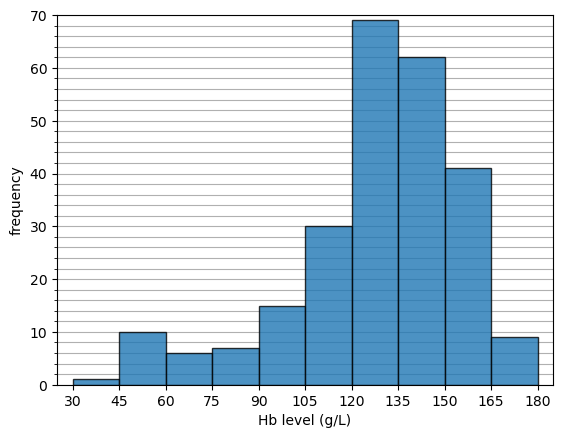

In [86]:
plt.hist(target, bins=10, range=(30,180), edgecolor='black', alpha=0.8)

plt.yticks(range(0,71, 10), minor=False)
plt.yticks(range(0, 71, 2), minor=True)

plt.xticks(range(30,181,15), minor=False)

ax = plt.gca()
ax.set_axisbelow(True)
plt.grid(True, which='both', axis='y')

plt.xlim(25,185)
plt.ylim(0,70)

plt.xlabel('Hb level (g/L)')
plt.ylabel('frequency')

plt.show()

In [87]:
# Allowable cross correlation threshold
threshold = 0.9

features = features_all

target_series = pd.Series(target, name='target')
correlation_with_target = features.corrwith(target_series).abs()

_, new_order = zip(*sorted(list(zip(correlation_with_target, features.columns)), reverse=True, key=lambda x: x[0]))
features = features[list(new_order)]

features_correlation_matrix = features.corr().abs()
upper_tri = features_correlation_matrix.where(np.triu(np.ones(features_correlation_matrix.shape), k=1).astype(bool))

# Identify all pairs of columns with correlation above the threshold upper_tri.loc[col1, col2]
high_corr_pairs = [(col1, col2, upper_tri.loc[col1, col2]) for col1 in upper_tri.columns for col2 in upper_tri.columns if col1 != col2 and upper_tri.loc[col1, col2] > threshold]

# Remove duplicate pairs (e.g., (A, B) and (B, A))
unique_high_corr_pairs = []
seen_pairs = set()
for col1, col2, corr_value in high_corr_pairs:
    if (col2, col1) not in seen_pairs:
        unique_high_corr_pairs.append((col1, col2, corr_value))
        seen_pairs.add((col1, col2))

to_remove = set([pair[0] if correlation_with_target[pair[0]] <= correlation_with_target[pair[1]] else pair[1] for pair in unique_high_corr_pairs])

# The selected data
features = features.drop(columns=to_remove)

# display(upper_tri)
display(features)


,NAIL_gsc_p=40,NAIL_H_p=30,NAIL_R_p=5,SKIN_Q_p=5,SKIN_H_p=55,SKIN_G_p=90,NAIL_Y_p=20,NAIL_G-B_MEAN,NAIL_Q_p=5,SKIN_R-G_MEAN,...,NAIL_V_p=5,NAIL_H_p=75,NAIL_G_STD,NAIL_H_p=40,SKIN_R_STD,NAIL_H_p=70,NAIL_H_p=55,NAIL_B_STD,NAIL_R-B_MEAN,NAIL_H_p=60
0,0.805674,0.073052,0.930876,-0.011562,0.124636,0.814050,1.330866,0.035101,-0.027359,0.217424,...,1.156863,0.167702,4.328387,0.091837,3.939649,0.151261,0.118421,5.165229,0.209281,0.126623
1,0.755650,0.064789,0.936073,-0.040823,0.168980,0.782787,1.289423,0.043598,-0.010420,0.234997,...,1.269717,0.112013,8.352373,0.073016,3.027229,0.106154,0.090989,7.273381,0.303354,0.093878
2,0.844972,0.069697,0.986547,-0.053082,0.216165,0.934694,1.456461,0.018203,-0.014849,0.156856,...,1.289490,0.145183,4.726686,0.088462,2.713952,0.134416,0.109524,4.390632,0.190717,0.119481
3,0.715517,0.084088,0.883178,-0.016830,0.138236,0.762500,1.122816,0.038191,-0.020254,0.262175,...,1.139279,0.139647,5.485297,0.093098,5.840474,0.133299,0.111083,7.120597,0.227664,0.120047
4,0.734488,0.054307,0.863850,0.009016,0.093098,0.719665,1.168894,0.029444,-0.009263,0.257135,...,1.246187,0.104735,7.754149,0.065169,3.304865,0.093098,0.074784,7.665176,0.222768,0.083355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.722222,0.051696,0.870000,-0.048815,0.150830,0.905405,1.113952,0.013942,-0.023808,0.198341,...,2.004057,0.177126,3.417167,0.068194,2.285012,0.147929,0.103022,3.726902,0.202025,0.115056
246,0.717593,0.035546,0.840000,0.029938,0.088443,0.720721,1.001679,0.013401,-0.041240,0.302624,...,1.856000,0.325843,3.621654,0.045466,3.316986,0.143371,0.069118,3.887764,0.237075,0.078444
247,0.755943,0.043630,0.884422,-0.066357,0.143605,0.837209,1.069615,0.045119,-0.030800,0.226532,...,2.921569,0.089753,4.625634,0.050262,3.068585,0.082396,0.066452,5.192988,0.278963,0.068539
248,0.742448,0.096983,0.905473,-0.184967,0.164931,0.854460,1.116397,0.094772,-0.057156,0.226215,...,4.358974,0.131341,3.375296,0.104167,1.625885,0.125000,0.113147,3.017230,0.334121,0.115927


In [88]:
features_new = SelectKBest(f_regression, k=10).fit_transform(features, target)

features_new_dict = {}

for i in range(features.shape[1]):
    column_key = features.keys()[i]
    column_values = features.values[:,i]
    for j in range(features_new.shape[1]):
        if list(features.values[:,i]) == list(features_new[:,j]):
            features_new_dict[column_key] = column_values

display(pd.DataFrame(features_new_dict))

features = pd.DataFrame(features_new_dict)

,NAIL_gsc_p=40,NAIL_H_p=30,NAIL_R_p=5,SKIN_Q_p=5,SKIN_H_p=55,SKIN_G_p=90,NAIL_Y_p=20,NAIL_G-B_MEAN,NAIL_Q_p=5,SKIN_R-G_MEAN
0,0.805674,0.073052,0.930876,-0.011562,0.124636,0.814050,1.330866,0.035101,-0.027359,0.217424
1,0.755650,0.064789,0.936073,-0.040823,0.168980,0.782787,1.289423,0.043598,-0.010420,0.234997
2,0.844972,0.069697,0.986547,-0.053082,0.216165,0.934694,1.456461,0.018203,-0.014849,0.156856
3,0.715517,0.084088,0.883178,-0.016830,0.138236,0.762500,1.122816,0.038191,-0.020254,0.262175
4,0.734488,0.054307,0.863850,0.009016,0.093098,0.719665,1.168894,0.029444,-0.009263,0.257135
...,...,...,...,...,...,...,...,...,...,...
245,0.722222,0.051696,0.870000,-0.048815,0.150830,0.905405,1.113952,0.013942,-0.023808,0.198341
246,0.717593,0.035546,0.840000,0.029938,0.088443,0.720721,1.001679,0.013401,-0.041240,0.302624
247,0.755943,0.043630,0.884422,-0.066357,0.143605,0.837209,1.069615,0.045119,-0.030800,0.226532
248,0.742448,0.096983,0.905473,-0.184967,0.164931,0.854460,1.116397,0.094772,-0.057156,0.226215


In [89]:

featurenames = []
Coefficients = []
R_values = []

for feature in range(features.shape[1]):
    column = features.iloc[:, feature]
    correlation_coefficient, p_value = pearsonr(column, target)
    featurenames.append(f"{features.columns[feature]}")
    Coefficients.append(int(np.sign(correlation_coefficient)))
    R_values.append(abs(correlation_coefficient))
    # print(f"Pearson R {features.columns[feature]} (column {feature + 1}) = {correlation_coefficient}")

results = pd.DataFrame({'Feature' : featurenames, 'Coefficient' : Coefficients, 'Pearson R value' : R_values}).sort_values('Pearson R value',ascending=False)
display(results)
print(features.shape)

,Feature,Coefficient,Pearson R value
0,NAIL_gsc_p=40,-1,0.540435
1,NAIL_H_p=30,-1,0.533206
2,NAIL_R_p=5,-1,0.507933
3,SKIN_Q_p=5,1,0.470837
4,SKIN_H_p=55,-1,0.462142
5,SKIN_G_p=90,-1,0.459335
6,NAIL_Y_p=20,-1,0.458938
7,NAIL_G-B_MEAN,-1,0.457766
8,NAIL_Q_p=5,1,0.414428
9,SKIN_R-G_MEAN,1,0.365121


(250, 10)


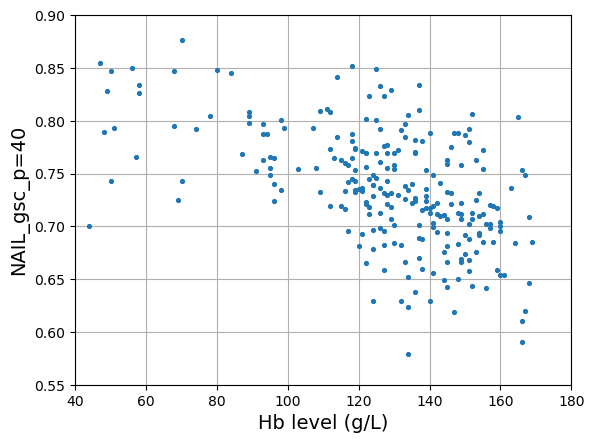

In [90]:
feature_to_plot = 'NAIL_gsc_p=40'

plt.scatter(target, features[feature_to_plot], s=30, marker='.')

plt.xlim(40, 180)
plt.ylim(0.55, 0.90)

ax = plt.gca()
ax.set_axisbelow(True)
plt.grid(True, which='major', axis='both')

plt.xlabel('Hb level (g/L)', size=14)
plt.ylabel(feature_to_plot, size=14)

plt.savefig('top_correlation_scatter.png', dpi=500)

plt.show()

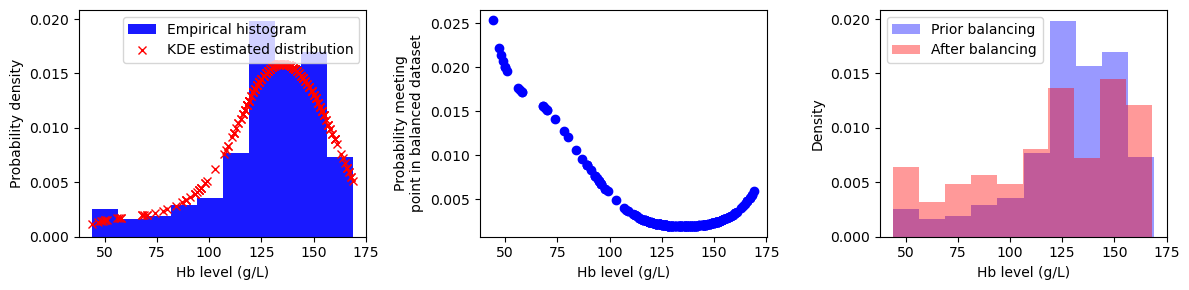

In [91]:
np.random.seed(42)

target_kde = stats.gaussian_kde(target,bw_method=0.5)(target)
weights = 1/target_kde
weights /= np.sum(weights)

patient_ids = metadata['PATIENT_ID']
balanced_patient_ids = np.random.choice(patient_ids,size=100,replace=False,p=weights)
balancing_mask = metadata['PATIENT_ID'].isin(balanced_patient_ids).values

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)

plt.hist(target,density=True,label='Empirical histogram',color='b',alpha=0.9)
plt.plot(target,target_kde,'x',color='r',label='KDE estimated distribution')

plt.legend()
plt.ylabel("Probability density")
plt.xlabel("Hb level (g/L)")

plt.subplot(1,3,2)
plt.plot(target,weights,'o',color='b')

plt.ylabel("Probability meeting\npoint in balanced dataset")
plt.xlabel("Hb level (g/L)")

plt.subplot(1,3,3)
plt.hist(target,density=True,alpha=0.4,label='Prior balancing',color='b')
plt.hist(target[balancing_mask],density=True,alpha=0.4,label='After balancing',color='r')

plt.xlabel("Hb level (g/L)")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

In [92]:
X = features[balancing_mask]
y = target[balancing_mask]

In [117]:
regressor_dict ={
    'RandomForest' : (sklearn.ensemble.RandomForestRegressor(n_jobs=-1, criterion='friedman_mse'), 
                        {'regressor__max_depth' : range(3, 8),
                         'regressor__max_features' : np.arange(0.6, 1.0, 0.1),
                         'regressor__min_samples_leaf' : np.linspace(1, 10, 5, dtype=int)}),

    'DecisionTree' : (sklearn.tree.DecisionTreeRegressor(),
                        {'regressor__max_depth' : range(1, 10),
                         'regressor__min_samples_leaf' : np.linspace(1, 10, 5, dtype=int)}),

    'ElasticNet'   : (sklearn.linear_model.ElasticNet(max_iter=10000),
                        {'regressor__l1_ratio' : [0.01, 0.1, 0.5, 0.9, 0.99],
                         'regressor__alpha' : np.logspace(-4, 4, num=100),
                        #  'regressor__tol' : np.logspace(-5, -4, 10)
                        }),

    'Neighbors'    : (sklearn.neighbors.KNeighborsRegressor(n_jobs=-1),
                        {'regressor__n_neighbors' : range(5, 10),
                         'regressor__weights' : ['uniform', 'distance'],
                         'regressor__algorithm' : ['ball_tree', 'kd_tree', 'brute'],
                         'regressor__p' : [1, 2]}),

    'Linear'       : (sklearn.linear_model.LinearRegression(n_jobs=-1),
                        {})
}

# choose your regressor here
regressorname = 'Neighbors'

regressor = regressor_dict[regressorname]

In [118]:
cv_scheme = sklearn.model_selection.KFold(n_splits=7)
scoring = sklearn.metrics.make_scorer(sklearn.metrics.root_mean_squared_error,greater_is_better=False)
model = sklearn.pipeline.Pipeline(
    steps=[
        #('feature_selection',SelectKBest(f_regression,k=20)),
        ('scaler', sklearn.preprocessing.RobustScaler()),
        ('regressor', regressor[0])
    ]
)

grid_searcher = sklearn.model_selection.GridSearchCV(model,
                                                    param_grid=regressor[1],
                                                    verbose=1,
                                                    cv=cv_scheme,return_train_score=True,
                                                    scoring=scoring)

In [119]:
grid_searcher.fit(X,y)

Fitting 7 folds for each of 30 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=7, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('regressor',
                                        KNeighborsRegressor(n_jobs=-1))]),
             param_grid={'regressor__algorithm': ['ball_tree', 'kd_tree',
                                                  'brute'],
                         'regressor__n_neighbors': range(5, 10),
                         'regressor__p': [2],
                         'regressor__weights': ['uniform', 'distance']},
             return_train_score=True,
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=1)

In [120]:
best_model = model.set_params(**grid_searcher.best_params_)
y_pred = sklearn.model_selection.cross_val_predict(best_model,X,y=y,cv=cv_scheme)
best_model.fit(X,y)

print(grid_searcher.best_score_, grid_searcher.best_params_)

-23.741521809330344 {'regressor__algorithm': 'ball_tree', 'regressor__n_neighbors': 9, 'regressor__p': 2, 'regressor__weights': 'distance'}


In [121]:
if regressorname == 'RandomForest':
    rf_model = best_model.named_steps['regressor']

    # Access the individual trees
    trees = rf_model.estimators_

    # Inspect the root node of each tree
    root_features = [[tree.tree_.feature[0]] for tree in trees]

    # Count the occurrences of each feature as the root node
    feature_counts = pd.Series(root_features).value_counts()

    # Map feature indices to feature names
    feature_names = X.columns
    feature_counts.index = feature_counts.index.map(lambda idx: feature_names[idx])

    print("Feature chosen as the root node in each tree:")
    print(feature_counts)
elif regressor[0] == 'DecisionTree':
    sklearn.tree.export_graphviz(decision_tree = model.named_steps['regressor'], out_file ='tree.png')

In [122]:
test_patients = ~balancing_mask

X_test = features[test_patients]
y_test = target[test_patients]

In [123]:
y_pred_test = best_model.predict(X_test)
val_rmse = sklearn.metrics.root_mean_squared_error(y,y_pred)
test_rmse = sklearn.metrics.root_mean_squared_error(y_test,y_pred_test)

Neighbors
Validation set bias: 3.3 g/L
Validation set (bias - 1.96*SD, bias + 1.96*SD): (-43.3,49.8) g/L)
------
Validation RSME: 23.978195633823617 Test RSME: 16.107932321209198
------
Best paremeters: {'regressor__algorithm': 'ball_tree', 'regressor__n_neighbors': 9, 'regressor__p': 2, 'regressor__weights': 'distance'}
------


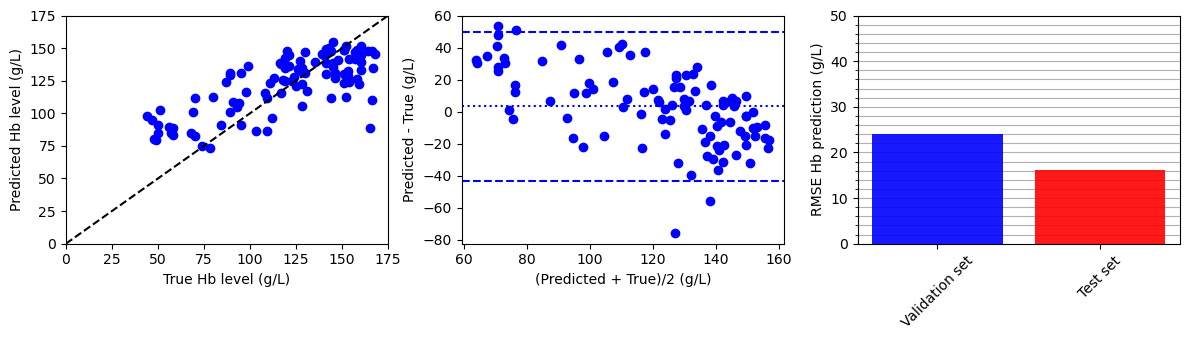

In [136]:
print(regressorname)
plt.figure(figsize=(12,3.5))
plt.subplot(1,3,1)

plt.plot(y,y_pred,'bo',label='Validation set')
# plt.plot(y_test,y_pred_test,'rx',label='Test set')
plt.plot(np.linspace(0,180),np.linspace(0,180),color='k',linestyle='dashed')
plt.xlim(0,175)
plt.ylim(0,175)

# plt.legend()
plt.ylabel("Predicted Hb level (g/L)")
plt.xlabel("True Hb level (g/L)")

plt.subplot(1,3,2)
sets = [[y, y_pred,'Validation set'],
        [y_test,y_pred_test, 'Test set']]

sets = [sets[0]]

marker_style = {"Validation set":'o','Test set':'x'}
colors = {"Validation set": 'b','Test set':'r'}

for _true,_pred, _set_type in sets:
    
    _avg = (_true + _pred)/2.
    _diff = _pred - _true
    
    _SD = np.std(_diff)
    _bias = np.mean(_diff)
    
    color = colors[_set_type]
    plt.plot(_avg,_diff,color=color,linestyle='None', marker=marker_style[_set_type])
    
    plt.axhline(_bias,linestyle='dotted',color=color)
    
    plt.axhline(_bias + 1.96*_SD,linestyle='dashed',color=color)
    plt.axhline(_bias - 1.96*_SD,linestyle='dashed',color=color)
    
    print(f'{_set_type} bias: {_bias:.1f} g/L')
    print(f'{_set_type} (bias - 1.96*SD, bias + 1.96*SD): ({_bias - 1.96*_SD:.1f},{_bias + 1.96*_SD:.1f}) g/L)')
    
    print('------')

plt.ylabel("Predicted - True (g/L)")
plt.xlabel("(Predicted + True)/2 (g/L)")


print('Validation RSME:',val_rmse, 'Test RSME:', test_rmse)
print('------')
print('Best paremeters:', grid_searcher.best_params_)
print('------')

plt.subplot(1,3,3)

plt.bar([0,1],[val_rmse,test_rmse],color=['b','r'],alpha=0.9)
plt.xticks([0,1],['Validation set','Test set'],rotation=45)
plt.ylabel("RMSE Hb prediction (g/L)")
ax = plt.gca()
ax.set_axisbelow(True)
plt.yticks(range(0,52, 2), minor=True)
plt.grid(True, which='both', axis='y')
plt.ylim(0,50)

plt.tight_layout()
plt.savefig(f'{regressorname}.png', dpi=500)
plt.show()


# Own finger trial:

,PATIENT_ID,MEASUREMENT_DATE,HB_LEVEL_GperL,NAIL_BOUNDING_BOXES,SKIN_BOUNDING_BOXES,REF_BOUNDING_BOXES
0,1,Yaron,0,"[[671, 1716, 943, 2058], [1009, 1331, 1294, 16...","[[638, 2485, 892, 2879], [1059, 2054, 1321, 24...","[1500, 2000]"
1,2,Ties,0,"[[635, 1793, 842, 2072], [883, 1585, 1120, 184...","[[573, 2301, 780, 2600], [884, 2093, 1122, 240...","[1300, 1200]"


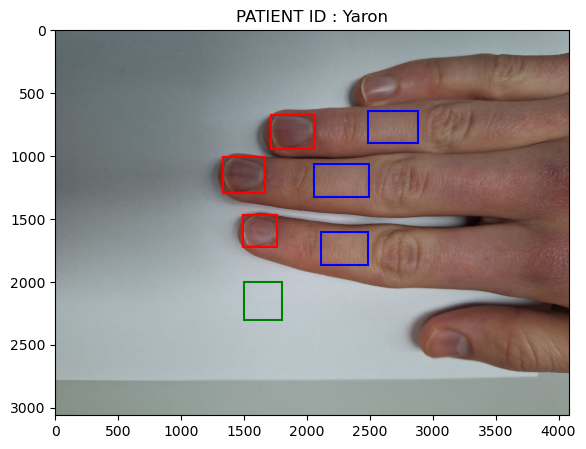

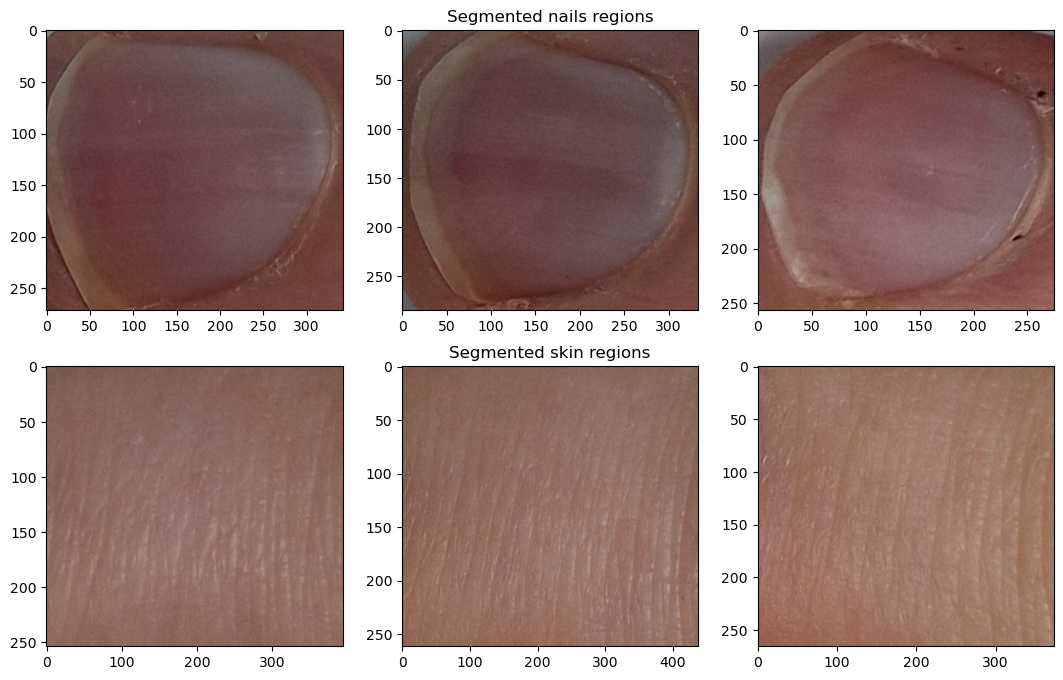

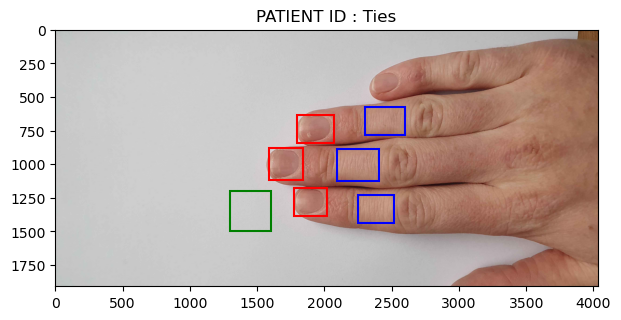

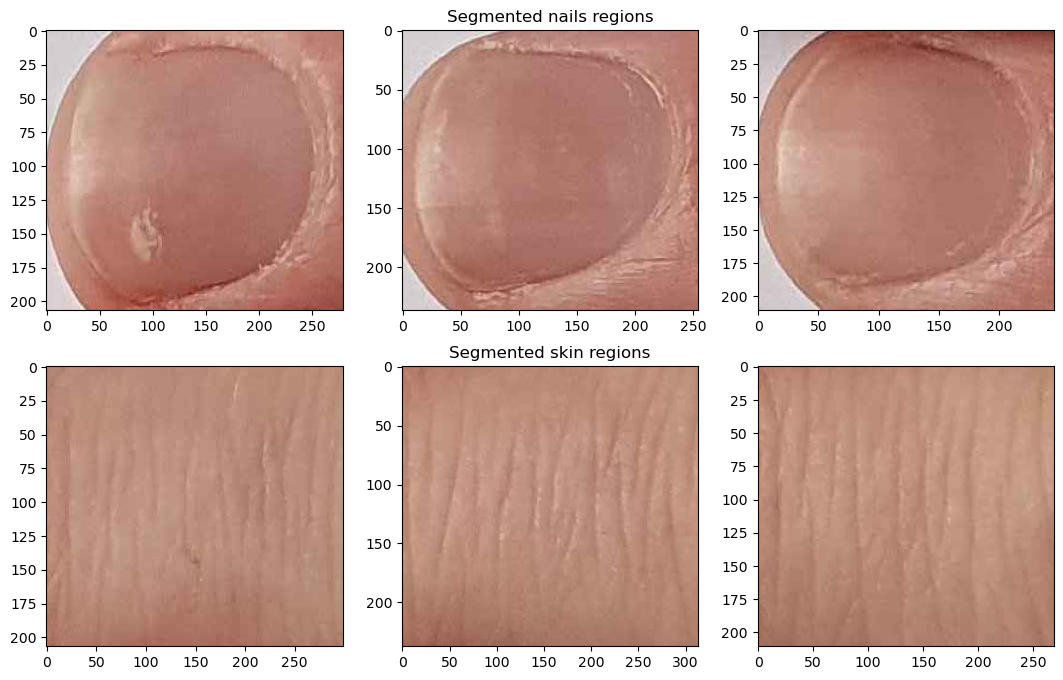

In [125]:
own_image_folder = './own_fingernails/photo/'
own_metadata = pd.read_csv('./own_fingernails/own_metadata.csv')

N_MAX_IMAGES = 2

own_metadata['NAIL_BOUNDING_BOXES'] = own_metadata['NAIL_BOUNDING_BOXES'].apply(json.loads)
own_metadata['SKIN_BOUNDING_BOXES'] = own_metadata['SKIN_BOUNDING_BOXES'].apply(json.loads)
own_metadata['REF_BOUNDING_BOXES'] = own_metadata['REF_BOUNDING_BOXES'].apply(json.loads)
own_metadata.shape
display(own_metadata.head())


for j,(_, row) in enumerate(own_metadata.iterrows()):
    
    if j ==  N_MAX_IMAGES:
        break
    
    img_path = os.path.join(own_image_folder,f'{row.PATIENT_ID}.jpg')
    
    img = skio.imread(img_path)
    
    plt.figure(figsize=(7,5))
    plt.imshow(img)

    nails_bboxes = row.NAIL_BOUNDING_BOXES
    skin_bboxes  = row.SKIN_BOUNDING_BOXES
    
    ax = plt.gca()
    
    for _color,_bboxes in zip(['r','b'],[nails_bboxes,skin_bboxes]):
        for top,left,bot,right in _bboxes:
            
            w,h = right-left,bot-top
            
            rectangle = mpatches.Rectangle(xy=(left,top),width=w,height=h,fill=None,
                                           color=_color,linewidth=1.5)
            
            ax.add_patch(rectangle)
            
    white_region_rectangle = mpatches.Rectangle(xy=own_metadata['REF_BOUNDING_BOXES'][j],width=300,height=300,fill=None,
                                           color='green',linewidth=1.5)
    ax.add_patch(white_region_rectangle)
    
    plt.title(f"PATIENT ID : {row.MEASUREMENT_DATE}")
    
    fig,axs = plt.subplots(2,3,figsize=(13,8))
    axs = axs.ravel()
    
    all_bboxes = nails_bboxes + skin_bboxes
    
    for i,(top,left,bot,right) in enumerate(all_bboxes):
        axs[i].imshow(img[top:bot,left:right],aspect='auto')
        if i == 1:
            axs[i].set_title("Segmented nails regions")
        if i == 4:
            axs[i].set_title("Segmented skin regions")
        
    plt.show()

In [126]:
own_images = defaultdict(list)

for j,(_, row) in tqdm.tqdm(enumerate(own_metadata.iterrows())):
    img_path = os.path.join(own_image_folder,f'{row.PATIENT_ID}.jpg')

    img = skio.imread(img_path)
    
    nails_bboxes = row.NAIL_BOUNDING_BOXES
    skin_bboxes  = row.SKIN_BOUNDING_BOXES
    
    for _tissue_site,_bboxes in zip(['NAIL','SKIN'],[nails_bboxes,skin_bboxes]):
        for finger_num,(top,left,bot,right) in enumerate(_bboxes,start=1):
            
            key = f'{_tissue_site}_{finger_num}'
            own_images[key].append(img[top:bot,left:right])
            
    x_ref, y_ref = own_metadata['REF_BOUNDING_BOXES'][j]
    own_images['WHITE_REF'].append(img[y_ref:y_ref + 300, x_ref:x_ref + 300])

2it [00:00,  3.11it/s]


# Feature extraction

In [127]:
own_features = pd.DataFrame({})

own_nail_features = pd.DataFrame([calculate_features(imgs, ref_img) for imgs, ref_img in zip(zip(*[own_images[f'NAIL_{finger_num}'] for finger_num in [1,2,3]]), own_images['WHITE_REF'])]).rename(columns=lambda x: f'NAIL_{x}')
own_skin_features = pd.DataFrame([calculate_features(imgs, ref_img) for imgs, ref_img in zip(zip(*[own_images[f'SKIN_{finger_num}'] for finger_num in [1,2,3]]), own_images['WHITE_REF'])]).rename(columns=lambda x: f'SKIN_{x}')

own_features = pd.concat([own_features, own_nail_features, own_skin_features],axis=1)    

own_features = own_features[features.columns]

# to replace invalid values
own_features.replace(np.inf, 0, inplace=True)

display(own_features)

C:\Users\tiesb\AppData\Local\Temp\ipykernel_2524\2263886866.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  hls_features['H_MEDIAN'] = np.median(h) / np.median(white_ref_h)
C:\Users\tiesb\AppData\Local\Temp\ipykernel_2524\2263886866.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  hls_features['S_MEDIAN'] = np.median(s) / np.median(white_ref_s)
C:\Users\tiesb\AppData\Local\Temp\ipykernel_2524\2263886866.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  feature_value = np.percentile(color,percentile_level) / np.median(ref_color)
C:\Users\tiesb\AppData\Local\Temp\ipykernel_2524\2263886866.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  hsv_features['H_MEDIAN'] = np.median(h) / np.median(white_ref_h)
C:\Users\tiesb\AppData\Local\Temp\ipykernel_2524\2263886866.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  hsv_features['V_MEDIAN'] = np.median(v) / np.median(white_ref_v)
C:\Users\tiesb\App

,NAIL_gsc_p=40,NAIL_H_p=30,NAIL_R_p=5,SKIN_Q_p=5,SKIN_H_p=55,SKIN_G_p=90,NAIL_Y_p=20,NAIL_G-B_MEAN,NAIL_Q_p=5,SKIN_R-G_MEAN
0,0.402027,0.032933,0.486772,0.043693,0.075889,0.641414,0.499474,0.008614,0.065767,0.215683
1,0.673235,0.000000,0.822660,0.000000,0.000000,0.748768,0.000000,0.059489,0.000000,0.224352


# Hemoglobin estimation

In [128]:
Hb_prediction = best_model.predict(own_features)
print(f'Hb-gehalte Yaron: {round(Hb_prediction[0], 1)} g/L \nHb-gehalte Ties:  {round(Hb_prediction[1], 1)} g/L')
print(f'Mean true value training dataset: {round(np.mean(target),1)} g/L')
print(f'Mean predicted value training dataset: {round(np.mean(best_model.predict(features)),1)} g/L')

Hb-gehalte Yaron: 151.7 g/L 
Hb-gehalte Ties:  151.4 g/L
Mean true value training dataset: 127.6 g/L
Mean predicted value training dataset: 126.7 g/L
